# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against ANGUS criteria
3. Assessing if there are interesting subgroup(s) which are missed by the criteria

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "angus"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Study questions

1. How well do the guidelines detect sepsis (Angus criteria) in the antibiotics/culture subset?
2. How well do the guidelines predict mortality (in-hospital) in the antibiotics/culture subset?
3. What factors would improve the sensitivity of the guidelines?
4. What factors would improve the specificity of the guidelines?

## Angus criteria evaluation

In [3]:
yhat = df.sepsis3.values
print('\n SEPSIS-3 guidelines for Angus criteria sepsis \n')
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))
su.print_cm(y, yhat, header1='ang',header2='sep3') # print confusion matrix


 SEPSIS-3 guidelines for Angus criteria sepsis 

Accuracy = 0.595797825448

Confusion matrix
      	ang=0 	ang=1 
sep3=0	  2076	  1274	NPV=61.97
sep3=1	  1477	  1979	PPV=57.26
   	58.43	60.84	Acc=59.58
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

For Angus criteria we do not adjust for other factors when presenting the AUROCs.

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)

In [5]:
# reproduce the AUC table
su.print_auc_table(preds, y, preds_header)
su.print_auc_table_to_file(preds, y, preds_header=preds_header,
                           filename='auc-table.csv')

     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.607 [0.594, 0.620]	0.435 [0.414, 0.456]	0.179 [0.162, 0.196]	0.227 [0.206, 0.249]	
qsofa	0.424               	0.601 [0.588, 0.613]	0.270 [0.259, 0.281]	0.356 [0.344, 0.368]	
sofa 	< 0.001               	< 0.001               	0.682 [0.670, 0.695]	0.872 [0.866, 0.878]	
mlods	< 0.001               	< 0.001               	0.600               	0.684 [0.672, 0.697]	


## Operating point statistics

This section evaluates the standard operating point statistics:

* sensitivity (% of true positives which are correctly classified)
* specificity (% of true negatives which are correctly classified)
* positive predictive value (given a positive prediction is made, what % are correct)
* negative predictive value (given a negative prediction is made, what % are correct)
* F1 score (harmonic mean of sensitivity and PPV)

In addition, we evaluate the number of false positives per 100 cases, or NFP/100. We feel this gives helpful perspective in interpretting the positive predictive value of the prediction and its relationship to the prevalance of the outcome. In this context, the measure can be summarized as: given 100 patients with suspected infection, how many will each algorithm inappropriately give a positive prediction?

In [6]:
# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_all = [df.sepsis3.values,
            df.sofa.values >= 2,
            df.sirs.values >= 2,
            df.mlods.values >= 2]
yhat_names = ['seps3', 'SOFA', 'SIRS', 'mLODS']

# define "targets", angus critera
y_all = [y for x in yhat_names]

stats_all = su.get_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=target_header)

In [7]:
# example of NFP/100
N_PATIENTS = 100
score_name = 'seps3'

idxScore = np.where([x==score_name for x in yhat_names])[0][0]
score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
score_ppv = stats_all[idxScore,6]/100.0

N_POSITIVES = N_PATIENTS*score_pos
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are false.'.format(N_POSITIVES, N_POSITIVES*(1-score_ppv)))

For 100.00 patients, 50.78 positives.
Of the 50.78 positives, 21.70 are false.


A similar question can be asked: given 100 patients with suspected infection, how many will each algorithm  appropriately give a positive prediction?

In [8]:
# example of NTP/100
N_PATIENTS = 100
score_name = 'seps3'

idxScore = np.where([x==score_name for x in yhat_names])[0][0]
score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
score_ppv = stats_all[idxScore,6]/100.0

N_POSITIVES = N_PATIENTS*score_pos
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are true.'.format(N_POSITIVES, N_POSITIVES*(score_ppv)))

For 100.00 patients, 50.78 positives.
Of the 50.78 positives, 29.08 are true.


In [9]:
print('\nRepeating the above for all scores...')
print('\nscore\tNTP/100\tNFP/100')
for score_name in yhat_names:
    idxScore = np.where([x==score_name for x in yhat_names])[0][0]
    score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
    score_ppv = stats_all[idxScore,6]/100.0

    N_POSITIVES = N_PATIENTS*score_pos
    print('{:5s}\t{:2.2f}\t{:2.2f}'.format(score_name, N_POSITIVES*(score_ppv), N_POSITIVES*(1-score_ppv)))


Repeating the above for all scores...

score	NTP/100	NFP/100
seps3	29.08	21.70
SOFA 	43.90	40.52
SIRS 	39.99	37.54
mLODS	37.78	27.95


Now we print out the operating point statistics.

In [10]:
su.print_op_stats(stats_all,
               yhat_names=yhat_names,
               header=target_header)

Metric


     	seps3               	SOFA                	SIRS                	mLODS               
TN   	 2076           	  795           	  998           	 1651           
FP   	 1477           	 2758           	 2555           	 1902           
FN   	 1274           	  265           	  531           	  682           
TP   	 1979           	 2988           	 2722           	 2571           
Sens 	60.84 [0.59, 0.63]	91.85 [0.91, 0.93]	83.68 [0.82, 0.85]	79.03 [0.78, 0.80]
Spec 	58.43 [0.57, 0.60]	22.38 [0.21, 0.24]	28.09 [0.27, 0.30]	46.47 [0.45, 0.48]
PPV  	57.26 [0.56, 0.59]	52.00 [0.51, 0.53]	51.58 [0.50, 0.53]	57.48 [0.56, 0.59]
NPV  	61.97 [0.60, 0.64]	75.00 [0.72, 0.78]	65.27 [0.63, 0.68]	70.77 [0.69, 0.73]
F1   	59.00             	66.41             	63.82             	66.55             
NTP  	29.08             	43.90             	39.99             	37.78             
NFP  	21.70             	40.52             	37.54             	27.95             


# Appendix

In the main body of the paper, we only evaluate operating point statistics for Angus criteria. Below, we reproduce ROC curves for the readers' interest.

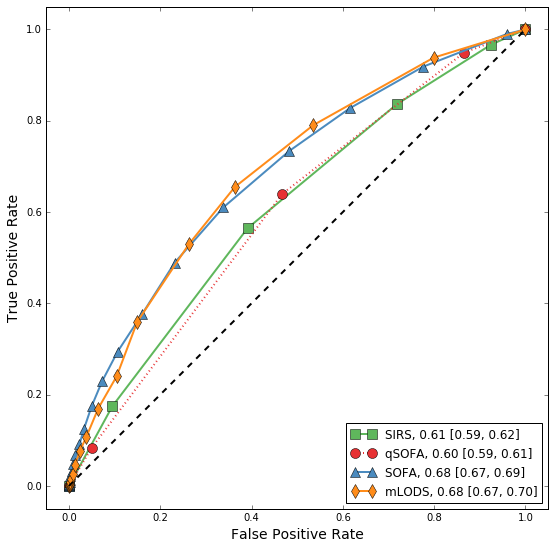

In [11]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'mLODS'}

# plot the data
plt.figure(figsize=[9,9])

# calculate and plot ROC for each score
for pred in ['sirs','qsofa','sofa','mlods']:
    if pred=='sepsis3':
        continue
        
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against ' + target_header,fontsize=14)
plt.show()

## Histograms comparing qSOFA

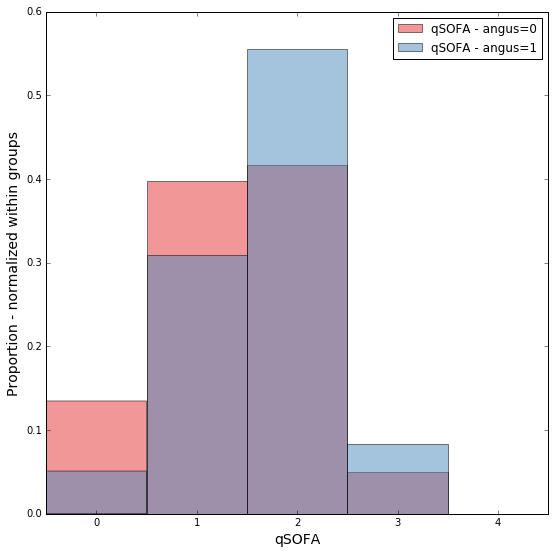

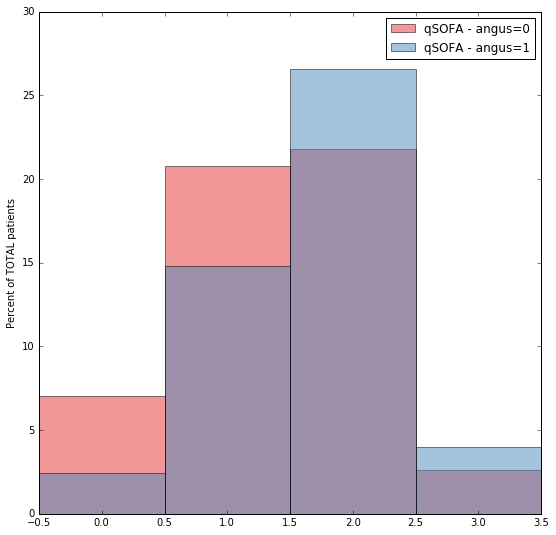

In [12]:
# histogram of the qSOFA values in septic/non-septic population
qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

prevalence = np.mean(y)

# plot the data
plt.figure(figsize=[9,9])
n0, bins0, patches0 = plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
n1, bins1, patches1 = plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Proportion - normalized within groups',fontsize=14)

plt.figure(figsize=[9,9])

N = len(y)
plt.bar(bins0[0:-1], 100.0*n0/N*qsofa_alive.shape[0], width=1, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
plt.bar(bins1[0:-1], 100.0*n1/N*qsofa_dead.shape[0], width=1, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')
plt.legend()
plt.ylabel('Percent of TOTAL patients')
plt.show()

In [13]:
# what % of people had a score less than 2? from the original paper's numbers on UPMC validation cohort
n_dead=1289
n_alive=6643
N = n_dead+n_alive

gt2_dead = {'sirs': 0.91,
           'sofa': 0.98,
           'lods': 0.98,
           'qsofa': 0.92}

gt2_alive = {'sirs': 1-0.17,
           'sofa': 1-0.10,
           'lods': 1-0.14,
           'qsofa': 1-0.19}

for i in gt2_dead.keys():
    n_gt2 = n_dead*gt2_dead[i] + n_alive*gt2_alive[i]
    n_lt2 = n_dead*(1-gt2_dead[i]) + n_alive*(1-gt2_alive[i])
    print('{:5s}: {:4.0f} of {:4.0f} have score > 2 ({:2.2f}%).'.format(i, n_gt2, n_gt2+n_lt2, 100.0*(n_gt2)/(n_gt2+n_lt2)))
    
# Numbers from article:
# (88%) - LODS
# (91%) - SOFA
# (84%) - SIRS
# ? - qSOFA

lods : 6976 of 7932 have score > 2 (87.95%).
sirs : 6687 of 7932 have score > 2 (84.30%).
qsofa: 6567 of 7932 have score > 2 (82.79%).
sofa : 7242 of 7932 have score > 2 (91.30%).
